# Start-up

In [14]:
import sys
import time
from numpy import *
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from control_hugo import red_pitaya_control,red_pitaya_app
import socket
import struct

AppName = "lock_in+pid_for_qudi"
rp_ip = 'rp-f0a83e.local'
port = 22
filename = "test.npz"
pwd = 'quantuM2015'

rp=red_pitaya_app(AppName=AppName,host=rp_ip,port=port,filename=filename,password=pwd)

auth method: pass
Remote Command: uname -a
Remote Command: echo $SSH_CONNECTION
rp.osc.load(): /opt/redpitaya/www/apps/lock_in+pid_for_qudi/py/osc.py
Remote Command: /opt/redpitaya/www/apps/lock_in+pid_for_qudi/py/osc.py
rp.lock_in+pid_for_qudi.load(): /opt/redpitaya/www/apps/lock_in+pid_for_qudi/py/lock.py
Remote Command: /opt/redpitaya/www/apps/lock_in+pid_for_qudi/py/lock.py
Remote Command: cat /opt/redpitaya/www/apps/lock_in+pid_for_qudi/index.html
Remote Command: /opt/redpitaya/bin/calib -r -v


In [ ]:
rp.ssh.close()

In [ ]:
print(rp.check_connection())

# Example

In [ ]:
import logging
logging.basicConfig()
logging.getLogger("paramiko").setLevel(logging.WARNING)
rp.verbose = False

In [ ]:
# Set params
rp.lock.ramp_step = 1000
rp.lock.ramp_low_lim = 0
rp.lock.ramp_hig_lim = 8191
rp.lock.ramp_enable = 1
rp.lock.out2_sw = 12

rp.lock.oscA_sw = 1
rp.lock.oscB_sw = 2
rp.lock.trig_sw = 8

rp.get_adc_dac_calib()

trigger_type = 6  # 6 is external, 1 is manual

In [ ]:
# Decimation only allows this values: 1,8,64, 1024, 8192, 65536
# The oscilloscope data points will be separated by 2^(dec-1) * 8 ns
dec = 1 # [1,8,64, 1024, 8192, 65536]

rp.osc_trig_fire(trig=trigger_type,dec=dec)
sleep(dec *8e-9*2**14 + 0.2)
rp.get_curv(log='ruido info' )

rp.save()

In [ ]:
# Access last acquisition values
ch1_val = mean( rp.data[-1][2]['ch1'])
ch1_err =  std( rp.data[-1][2]['ch1'])

ch2_val = mean( rp.data[-1][2]['ch2'])
ch2_err =  std( rp.data[-1][2]['ch2'])

ch1_act = (ch1_val + rp.calib_params['FE_CH1_DC_offs'])*float(rp.calib_params['FE_CH1_FS_G_HI'])/2**32*100/8192
ch2_act = (ch2_val + rp.calib_params['FE_CH2_DC_offs'])*float(rp.calib_params['FE_CH2_FS_G_HI'])/2**32*100/8192


In [ ]:
# plot last acquisition
rp.plot(num=0)

In [ ]:
rp.get_adc_dac_calib()

print(repr(rp.calib_params))

In [ ]:
rp.plot(num=1)

In [ ]:
rp.plot(num=-1)

# Test Real-time acquisition

## Single acquisitions

In [ ]:
rp.get_curv()

In [ ]:
len(rp.data)

In [ ]:
latest_acq = rp.data[-1]
latest_acq_number = latest_acq[0]
latest_acq_time = latest_acq[1]
latest_acq_data = latest_acq[2]
print("Acq_num: ",latest_acq_number,"  | Timestamp: ",datetime.fromtimestamp(latest_acq_time))

In [ ]:
t_idx = latest_acq_data['i']
print("Time data: ",t_idx)

In [ ]:
ch1 = latest_acq_data['ch1']
print("Ch. 1 data: ",ch1)

In [ ]:
ch2 = latest_acq_data['ch2']
print("Ch. 2 data: ",ch2)

In [ ]:
dec = latest_acq_data['dec']
tau = 8*2**latest_acq_data['dec']
t = [x * tau for x in t_idx]
print(t)

In [ ]:
print("dec:",dec,"=> Tau: ",tau,"ns")

In [ ]:
plt.plot(t,ch1)
plt.plot(t,ch2)

## Stream

In [7]:
# Start streaming specific signals
rp.start_streaming(signals='in1 in2')

# Collect data for a while (e.g., 10 seconds)
# time.sleep(10)

# Stop streaming when done
# rp.stop_streaming()

Getting streaming for [in1 in2]
start_streaming(): Getting streaming for [in1 in2]
start_streaming():
rp_ip: 134.60.243.125
local_ip:  134.60.243.151 

cmd:  /opt/redpitaya/www/apps/lock_in+pid_for_qudi/py/data_dump.py  -s 134.60.243.151 -p 6000 --params in1 in2 

start_streaming(): filename=20250204_151948_dump.bin
remote: /opt/redpitaya/www/apps/lock_in+pid_for_qudi/py/data_dump.py  -s 134.60.243.151 -p 6000 --params in1 in2


In [15]:
rp.stop_streaming()

Streaming never started


In [46]:
HOST = "0.0.0.0"  # Listen on all available interfaces
PORT = 6000
FORMAT = "!fll"  # Struct format: float, long, long
SIZE = struct.calcsize(FORMAT)  # Calculate expected bytes size
print(SIZE)

received_data = []

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind(('', PORT))
    s.listen(1)  # Allow one connection
    print(f"Listening on port {PORT}...")

    connection, client_address = s.accept()
    print(f"Connection from {client_address}")

    start_time = time.time()
    while time.time() - start_time < 10:  # Run for 10 seconds
        try:
            # s.settimeout(1)  # Timeout for receiving
            data = connection.recv(SIZE)
            unpacked_data = struct.unpack(FORMAT, data)
            print(f"Received from {client_address}: {unpacked_data}")
            received_data.append(list(unpacked_data))
        except socket.timeout:
            continue
    print("Timeout reached. Exiting.")

#     TODO: close socket on exit, such that the data_dump script is cancelled


12
Listening on port 6000...
Connection from ('134.60.243.125', 58292)
Received from ('134.60.243.125', 58292): (0.0054836273193359375, 386924444, 3810)
Received from ('134.60.243.125', 58292): (0.008617401123046875, -1760559203, -3094)
Received from ('134.60.243.125', 58292): (0.011741876602172852, 386924448, -4092)
Received from ('134.60.243.125', 58292): (0.01476740837097168, 386924460, 3962)
Received from ('134.60.243.125', 58292): (0.017778873443603516, 386924446, -3254)
Received from ('134.60.243.125', 58292): (0.02079033851623535, 386924441, -3146)
Received from ('134.60.243.125', 58292): (0.023822784423828125, 386924446, 3268)
Received from ('134.60.243.125', 58292): (0.02684164047241211, 386924439, 2956)
Received from ('134.60.243.125', 58292): (0.029950857162475586, 386924444, 1962)
Received from ('134.60.243.125', 58292): (0.03298830986022949, 386924452, 3454)
Received from ('134.60.243.125', 58292): (0.03602290153503418, 386924440, -4062)
Received from ('134.60.243.125', 58

In [47]:
received_data

[[0.0054836273193359375, 386924444, 3810],
 [0.008617401123046875, -1760559203, -3094],
 [0.011741876602172852, 386924448, -4092],
 [0.01476740837097168, 386924460, 3962],
 [0.017778873443603516, 386924446, -3254],
 [0.02079033851623535, 386924441, -3146],
 [0.023822784423828125, 386924446, 3268],
 [0.02684164047241211, 386924439, 2956],
 [0.029950857162475586, 386924444, 1962],
 [0.03298830986022949, 386924452, 3454],
 [0.03602290153503418, 386924440, -4062],
 [0.03912186622619629, 386924451, -3414],
 [0.042150259017944336, -1760559202, 2604],
 [0.04517531394958496, 386924445, 2790],
 [0.04819226264953613, 386924448, -2812],
 [0.05127835273742676, 386924454, -4050],
 [0.05433464050292969, 386924444, -3584],
 [0.05736398696899414, 386924451, 3912],
 [0.060433387756347656, 386924447, 1558],
 [0.06346821784973145, 386924446, -4006],
 [0.06649231910705566, 386924447, 1006],
 [0.06960058212280273, -1760559202, -342],
 [0.0726308822631836, 386924451, 3914],
 [0.07567358016967773, 386924453,

In [48]:
t = [row[0] for row in received_data]
ch1 = [row[1] for row in received_data]
ch2 = [row[2] for row in received_data]

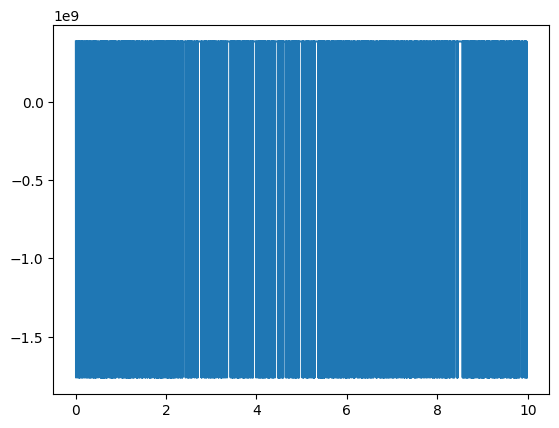

In [49]:
plt.plot(t,ch1)

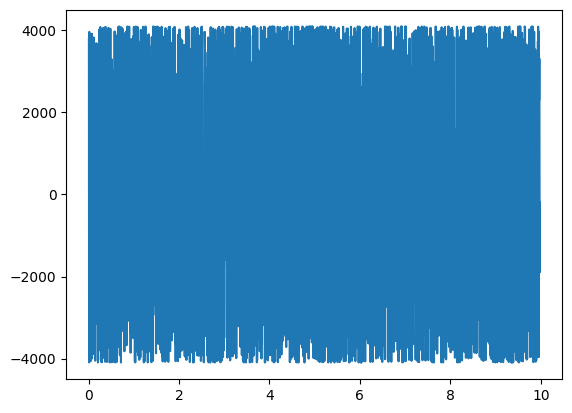

In [50]:
plt.plot(t,ch2)